# Rover project
Roberto Lucchesi - 1744941

# Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# custom modules
from graph import *
from AStar import *
from grid import *
from traj_gen import *


dataFolder = "data/"

### load data from csv file


# landmarks coordinates
Xlm = np.loadtxt(dataFolder +"Xlm.csv")
Ylm = np.loadtxt(dataFolder +"Ylm.csv")
pos_lm = np.array([Xlm, Ylm]).T # landmark positions

# map and obstacle map
mars_map = np.loadtxt(dataFolder +"map.csv", delimiter=",")
obstacle_map = np.loadtxt(dataFolder +"obstacle.csv", delimiter=",")


## Constants of the problem
maxVel = 0.5; # [m/s] maximum velocity of the rover 
LAxis = 1; # [m] length of the rover wheel axis



# Create mars_grid (45kmx30km, 10m resolution)
mars_grid = Grid(xlim = 45000, ylim = 30000, res = 10, 
            image = mars_map, obstacle = obstacle_map, 
            landmarks = pos_lm, corner = 'll') 


#plt.imshow(np.flipud(mars_grid.map), cmap='gray')
#plt.gca().invert_yaxis()
#plt.show()

# Task 1
- 1.1) Plot the trajectory of the rover in the map from P0 = (42.38, 11.59)km to P1 = (33.07,19.01)km
- 1.2) Plot the velocity profile of the rover
- 1.3) Plot the steering angle profile of the rover
- 1.4) Plot the rate of change of the steering angle profile of the rover

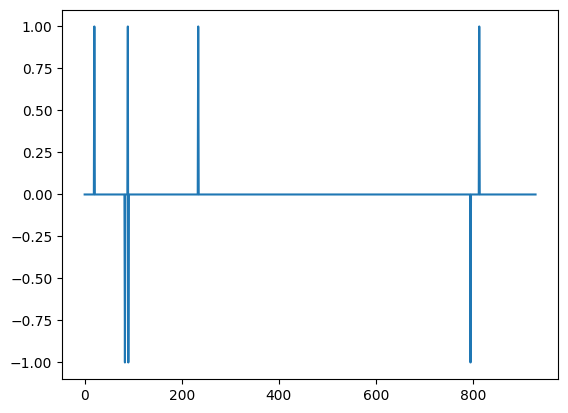

In [2]:
### TASK 1 ### --2.8s average runtime
P0 = (42.38*10**3, 11.59*10**3)
P1 = (33.07*10**3, 19.01*10**3)


## 1.1) Plot the trajectory of the rover in the map

# Create path with A*
path, gScore = AStar(mars_grid, P0, P1)
graph = Graph(path, mars_grid)
plt.figure(0)
plt.plot(np.diff(graph.directions))
plt.show()



# Get the trajectory of the rover


# 1.2) Plot the velocity profile of the rover
# 1.3) Plot the steering angle profile of the rover
# 1.4) Plot the rate of change of the steering angle profile of the rover

In [3]:
## Plot TASK 1

new_graph = shorten_path(graph, 0,0)


# Plot path
path_coords = [(node[0], node[1]) for node in path]
for coord in path_coords:
    plt.plot(coord[0]/10, coord[1]/10, 'b.',  markersize=1)

plt.imshow(np.flipud(mars_grid.map), cmap='gray')
plt.gca().invert_yaxis()

plt.plot(P0[0]/10, P0[1]/10, 'bo')
plt.plot(P1[0]/10, P1[1]/10, 'ro')
plt.show()
print("gScore: ", gScore)

# Task 2

In [ ]:
### TASK 2 ### -- 3min average runtime
# Go from P1 to P2

P2 = (10.87*10**3, 25.67*10**3)
path2, gScore2 = AStar(mars_grid, P1, P2) # Run A* from P1 to P2


In [ ]:
graph2 = Graph(path2, mars_grid)
plt.figure(0)
diff_abs = [abs(graph2.diff_arr[i]) for i in range(len(graph2.diff_arr))]
plt.plot(diff_abs)
plt.show()


In [ ]:
## Plot TASK 2

# Plot path



path_coords2 = [(node[0], node[1]) for node in path2]
for coord in path_coords: # path 1
    plt.plot(coord[0]/10, coord[1]/10, 'b.',  markersize=1)
for coord in path_coords2: # path 2
    plt.plot(coord[0]/10, coord[1]/10, 'r.',  markersize=1)
    
plt.imshow(np.flipud(mars_grid.map), cmap='gray')
plt.gca().invert_yaxis()
plt.plot(P0[0]/10, P0[1]/10, 'bo')
plt.plot(P1[0]/10, P1[1]/10, 'ro')
plt.plot(P2[0]/10, P2[1]/10, 'go')
plt.show()
print("gScore: ", gScore2)
